<a href="https://colab.research.google.com/github/OrMullerHahitti/MDLM_assignment/blob/main/Spaceship_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Environment Initialization

In [1]:
import sys



In [2]:
# Core libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

print("Environment initialized.")

Environment initialized.


# 2. Kaggle API Setup


# 3. Creating Data Directory and Downloading Dataset


In [3]:
# Skip Colab-specific upload (not needed locally)
# The kaggle.json should already be in the project directory or ~/.kaggle/

import os
import shutil

kaggle_file = 'kaggle.json'
destination_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
destination_path = os.path.join(destination_dir, kaggle_file)

# create .kaggle directory if needed
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# copy kaggle.json if it exists in project
if os.path.exists(kaggle_file):
    shutil.copy(kaggle_file, destination_path)
    os.chmod(destination_path, 0o600)
    print(f"Kaggle API configured from {kaggle_file}")
elif os.path.exists(destination_path):
    print("Kaggle API already configured.")
else:
    print(f"Warning: Please place {kaggle_file} in your project folder or ~/.kaggle/")

Kaggle API configured from kaggle.json


In [4]:
# Verify kaggle configuration
import os

kaggle_config = os.path.join(os.path.expanduser('~'), '.kaggle', 'kaggle.json')
if os.path.exists(kaggle_config):
    print(f"✓ Kaggle API configured at {kaggle_config}")
else:
    print("✗ Kaggle API not configured")

✓ Kaggle API configured at /Users/or/.kaggle/kaggle.json


In [5]:
# Create a dedicated directory for the dataset
import subprocess
import os

os.makedirs("data", exist_ok=True)

# Download the competition files using uv run (for local environment)
# This ensures the kaggle CLI from the uv virtualenv is used
result = subprocess.run(
    ["uv", "run", "kaggle", "competitions", "download", "-c", "spaceship-titanic", "-p", "data"],
    capture_output=True,
    text=True
)
print(result.stdout)
if result.stderr:
    print(result.stderr)

print("Download completed.")

spaceship-titanic.zip: Skipping, found more recently modified local copy (use --force to force download)

Download completed.


# 4. Extracting Files


In [6]:
# Extract the dataset ZIP file into the 'data' directory
!unzip -o data/spaceship-titanic.zip -d data

print("Files extracted into the 'data' folder.")


Archive:  data/spaceship-titanic.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          
Files extracted into the 'data' folder.


# 5. Loading Data

In [7]:
# Load the training and test CSV files from the data directory
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Spaceship Titanic - Machine Learning & Data Mining Project

### Based on CRISP-DM methodology
### Kaggle Competition - Binary Classification Task

# 1. Business Understanding

The goal of this project is to determine which passenger characteristics are linked to
being *Transported* after the anomaly on the Spaceship Titanic, and to build a model
that can accurately predict this outcome.

From a practical perspective, understanding these patterns is valuable because it helps
identify which factors - such as cabin location, travel conditions, or personal
attributes - play a meaningful role in the final result. This supports better decision-
making and improves our ability to reason about the situation based on data.

The problem is framed as a **binary classification task**, where the objective is to
predict the final outcome (Transported = True/False) using the available features.


# 2. Data Understanding 🤔

This chapter is dedicated to establishing a clear and structured understanding of the dataset, which serves as the foundational prerequisite for successful modeling. We will begin by reviewing variables, checking data quality (types, distributions), and performing a detailed analysis of missing data patterns. Following this initial review, the chapter will progress to a rigorous analysis of feature relationships. This involves applying specialized statistical methods-Spearman $\rho$, Cramér's V, and Kruskal-Wallis H Test-tailored to validate the strength of all associations across numerical, binary, and categorical features. The insights gathered here provide the necessary evidence to guide all subsequent decisions in the pipeline, including imputation, feature engineering, and model selection.


### 2.1 Dataset Variables

- **PassengerId** - identifier in the format `xxxx_yy`, representing group and passenger number  
- **HomePlanet** - passenger's planet of origin  
- **CryoSleep** - whether the passenger was in suspended animation  
- **Cabin** - structured as `Deck/Number/Side`  
- **Destination** - intended destination  
- **Age** - passenger’s age  
- **VIP** - VIP service indicator  
- **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - spending amounts  
- **Name** - passenger’s full name  
- **Transported** - target variable (True/False)

### 2.2 Initial Exploration


#### 2.2.1 Preview of the Data
To get an initial sense of the dataset, we display the first few rows of the training set.

In [8]:

# Display the first few rows of the training set
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


#### 2.2.2 Dataset Overview

The training dataset contains **8,693 rows** and **14 columns**, which include
13 explanatory variables and the binary target variable (`Transported`).  
The test dataset contains **4,277 rows** and the same explanatory variables,
but without the target column.

The features in the dataset describe several aspects of each passenger, including
demographic information, travel-related attributes, spending behavior, and cabin
assignment details. Together, these variables form a rich representation of the
passengers and provide the basis for understanding patterns related to the final outcome.

In [9]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (8693, 14)
Test shape: (4277, 13)


#### 2.2.3 Target Variable

`Transported` is the binary outcome indicating whether a passenger was transported
following the anomaly. The distribution is nearly balanced, with **4,378 passengers
(≈50.36%) labeled as True** and **4,315 passengers (≈49.64%) labeled as False**.  
This near balance indicates that there is no noticeable class bias that requires additional handling.




/var/folders/_9/m77fv7yj7v17s1l0d7wr4n3m0000gn/T/ipykernel_77282/3751945774.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


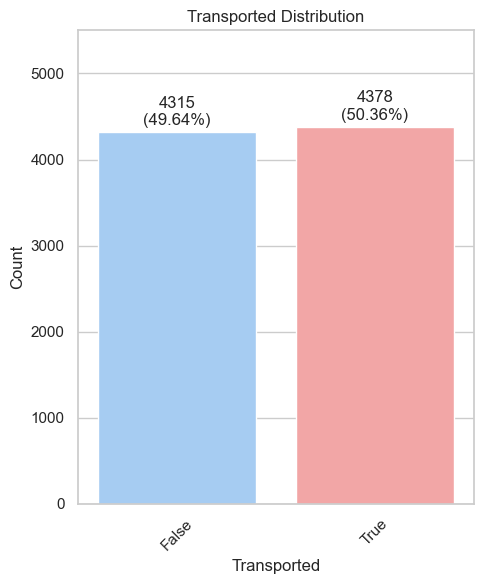

In [10]:
counts = train["Transported"].value_counts()
percentages = (train["Transported"].value_counts(normalize=True) * 100).round(2)

order = [False, True]
palette = ["#99CCFF", "#FF9999"]

plt.figure(figsize=(5, 6))
ax = sns.countplot(
    x="Transported",
    data=train,
    order=order,
    palette=palette
)

# Add labels above bars
for i, bar in enumerate(ax.patches):
    value = counts[order[i]]
    pct = percentages[order[i]]
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 50,
        f"{value}\n({pct}%)",
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.title("Transported Distribution")
plt.ylabel("Count")
plt.ylim(0, 5500)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.3 Data Types and Structure
We now examine the data types and non-null counts for each column to better understand
the structure of the dataset and identify potential issues such as missing values or
incorrect data types.

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


The dataset contains a mix of numerical and categorical features, and the column types
appear consistent with their expected content. Apart from the identifier and the target
variable, most features include some missing values at varying levels, which will be
addressed during data preparation.


### 2.4 Missing Values Analysis
Understanding how missing values are distributed in the dataset is essential before
moving to data preparation. We examine missingness at three levels: per feature, per
record, and across features to detect possible co-missingness patterns.


#### 2.4.1 Missing Values per Feature
We begin by examining missing values feature-wise to understand how much information is
missing in each column. The following table summarizes the number and percentage of
missing values for each feature, sorted from the most missing to the least.

In [12]:
# Missing values count
missing_count = train.isna().sum()

# Missing values percent
missing_percent = (train.isna().mean() * 100).round(2)

# Combine into a single DataFrame
missing_table = pd.concat(
    [missing_count, missing_percent],
    axis=1
)

missing_table.columns = ["Missing_Count", "Missing_Percent (%)"]

# Sort from most missing to least
missing_table.sort_values("Missing_Count", ascending=False)

,Missing_Count,Missing_Percent (%)
CryoSleep,217,2.50
ShoppingMall,208,2.39
VIP,203,2.34
HomePlanet,201,2.31
Name,200,2.30
Cabin,199,2.29
VRDeck,188,2.16
FoodCourt,183,2.11
Spa,183,2.11
Destination,182,2.09


Overall, the amount of missing data is low and fairly consistent across most features
(about 2%). Importantly, both the identifier (`PassengerId`) and the target variable
(`Transported`) contain no missing values. All other missing values will be handled later during data preparation using
appropriate imputation strategies.


#### 2.4.2 Missing Values per Record
Next, we look at how missingness is distributed across records to identify whether
certain rows contain unusually large gaps. This helps determine whether there are
records that may require special attention during data preparation.

In [13]:
# Count missing values per row
missing_per_row = train.isna().sum(axis=1)

# Distribution of missing counts (how many rows have X missing values)
missing_per_row_distribution = missing_per_row.value_counts().sort_index()

missing_per_row_distribution


0    6606
1    1867
2     203
3      17
Name: count, dtype: int64

The distribution of missing values per row shows that the large majority of records are
either complete (**6606 rows**) or have only one missing value (**1867 rows**). A smaller
number contain two (**203 rows**) or three (**17 rows**) missing fields. Since no record
is heavily incomplete, there is no immediate indication that any rows would need to be
removed during subsequent data processing.


#### 2.4.3 Missing Value Patterns
Finally, we examine whether certain features tend to be missing together. Identifying
such co-missingness patterns is important, since variables that are frequently missing
in the same records may not be suitable for imputing one another and could require
special handling during data preparation.

In [14]:
# Create a DataFrame indicating missingness per feature (True = missing)
missing_df = train.isna()

# Compute correlation between missingness of columns
missing_corr = missing_df.corr()

missing_corr

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HomePlanet,NaN,1.000000,-0.014804,0.007158,-0.001113,-0.011528,-0.008585,0.009729,-0.011897,0.010972,-0.006565,-0.017612,0.012128,NaN
CryoSleep,NaN,-0.014804,1.000000,0.010020,-0.002798,-0.018008,0.009436,-0.013004,-0.008055,0.013547,0.002218,0.011694,0.024627,NaN
Cabin,NaN,0.007158,0.010020,1.000000,-0.000894,-0.000529,0.006891,-0.000773,0.004344,-0.013899,-0.011730,-0.001606,-0.013228,NaN
Destination,NaN,-0.001113,-0.002798,-0.000894,1.000000,-0.004230,-0.001331,-0.004443,0.012138,0.003392,-0.004653,-0.010694,-0.001004,NaN
Age,NaN,-0.011528,-0.018008,-0.000529,-0.004230,1.000000,0.009762,-0.015471,0.001308,-0.001500,-0.015620,0.000717,-0.006042,NaN
VIP,NaN,-0.008585,0.009436,0.006891,-0.001331,0.009762,1.000000,-0.001210,-0.001451,-0.004273,-0.012063,-0.017753,-0.018648,NaN
RoomService,NaN,0.009729,-0.013004,-0.000773,-0.004443,-0.015471,-0.001210,1.000000,-0.010160,-0.001744,-0.004548,-0.010603,-0.017004,NaN
FoodCourt,NaN,-0.011897,-0.008055,0.004344,0.012138,0.001308,-0.001451,-0.010160,1.000000,-0.012473,0.006406,0.011251,0.004221,NaN
ShoppingMall,NaN,0.010972,0.013547,-0.013899,0.003392,-0.001500,-0.004273,-0.001744,-0.012473,1.000000,-0.012473,0.007771,-0.003944,NaN


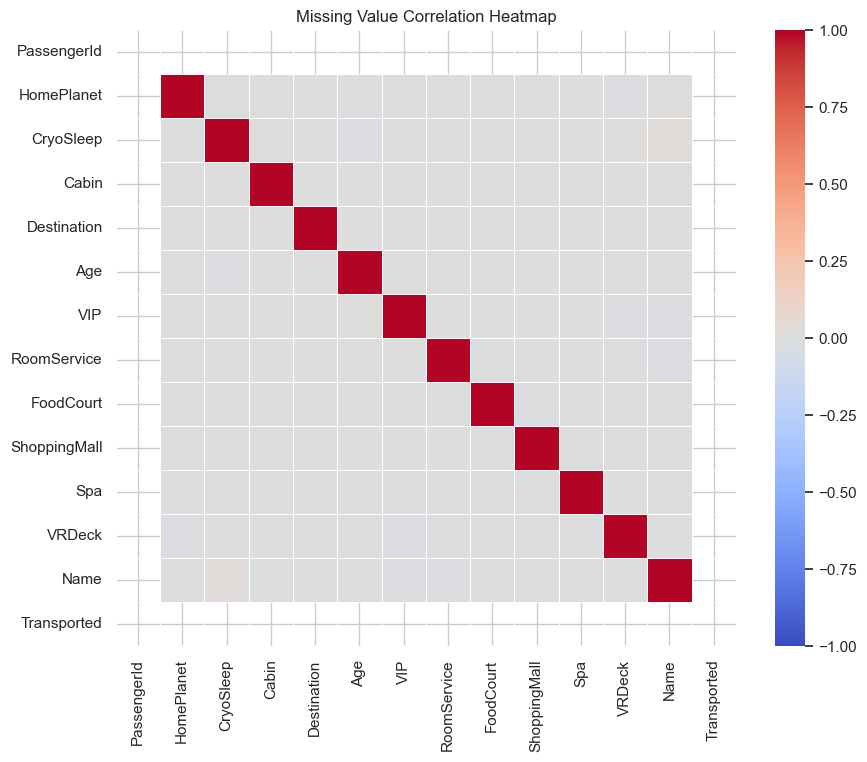

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    missing_corr,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    linewidths=0.5
)
plt.title("Missing Value Correlation Heatmap")
plt.show()

Pairwise correlations between missingness indicators are effectively zero, indicating
that missing values occur independently across features. The NaN entries for
`PassengerId` and `Transported` arise because these columns contain no missing values,
so their missingness indicators are constant and correlation is undefined. Together with
the fact that only a few rows contain more than one or two missing fields (and none
contain four or more), higher-order co-missingness is not a practical concern in this
dataset.


### 2.5 Descriptive Statistics

To gain an initial understanding of the numerical features, we examine basic summary
statistics such as central tendencies, dispersion, and range. This helps identify
potential irregularities, unusual values, and differences in scale that may influence
the preprocessing steps that follow.

In [16]:
# Select only numerical features
numeric_cols = train.select_dtypes(include=["float64", "int64"]).columns

# Display descriptive statistics for numerical columns
train[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


The numerical features display clear differences in both scale and distribution. The
five spending-related variables (`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`,
`VRDeck`) are highly right-skewed: their medians are zero, while their means and
standard deviations are large, and each contains extreme maximum values.
This indicates
that many passengers spent little or nothing, while a small number of individuals made
very large purchases.

In contrast, `Age` exhibits a more balanced distribution, with typical values centered
around the late 20s and no extreme outliers. The presence of age value 0 likely corresponds to infants younger than one year, rather
than data errors.

These observations highlight that the spending variables have a fundamentally different
structure from Age, with heavy concentration at zero and long right tails. This distinction
is important to keep in mind, as it may influence how these features behave in later stages
of the analysis.



### 2.6 Categorical Feature Exploration

We now examine the categorical features to understand their structure, the number of
distinct categories they contain, and the distribution of values within each feature.
This helps identify dominant categories, rare values, and potential issues to consider
later during encoding.


In [17]:
# Select categorical features (objects + boolean features represented as object)
categorical_cols = train.select_dtypes(include=["object", "bool"]).columns

# Display number of unique values in each categorical column
train[categorical_cols].nunique().sort_values()

CryoSleep         2
VIP               2
Transported       2
HomePlanet        3
Destination       3
Cabin          6560
Name           8473
PassengerId    8693
dtype: int64

The uniqueness counts confirm that the boolean features (`CryoSleep`, `VIP`,
`Transported`) contain exactly two distinct values, as expected. `PassengerId` has a
unique value for every record, indicating that it functions purely as an identifier.
In contrast, `Cabin` and `Name` exhibit very high cardinality, which suggests that they
cannot be used directly as categorical inputs and will require decomposition or
special handling during preprocessing.

In [18]:
categorical_to_plot = ["HomePlanet", "Destination", "CryoSleep", "VIP"]
for col in categorical_to_plot:
    print(f"\nValue counts for {col}:\n")
    print(train[col].value_counts(dropna=False))


Value counts for HomePlanet:

HomePlanet
Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: count, dtype: int64

Value counts for Destination:

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
NaN               182
Name: count, dtype: int64

Value counts for CryoSleep:

CryoSleep
False    5439
True     3037
NaN       217
Name: count, dtype: int64

Value counts for VIP:

VIP
False    8291
NaN       203
True      199
Name: count, dtype: int64


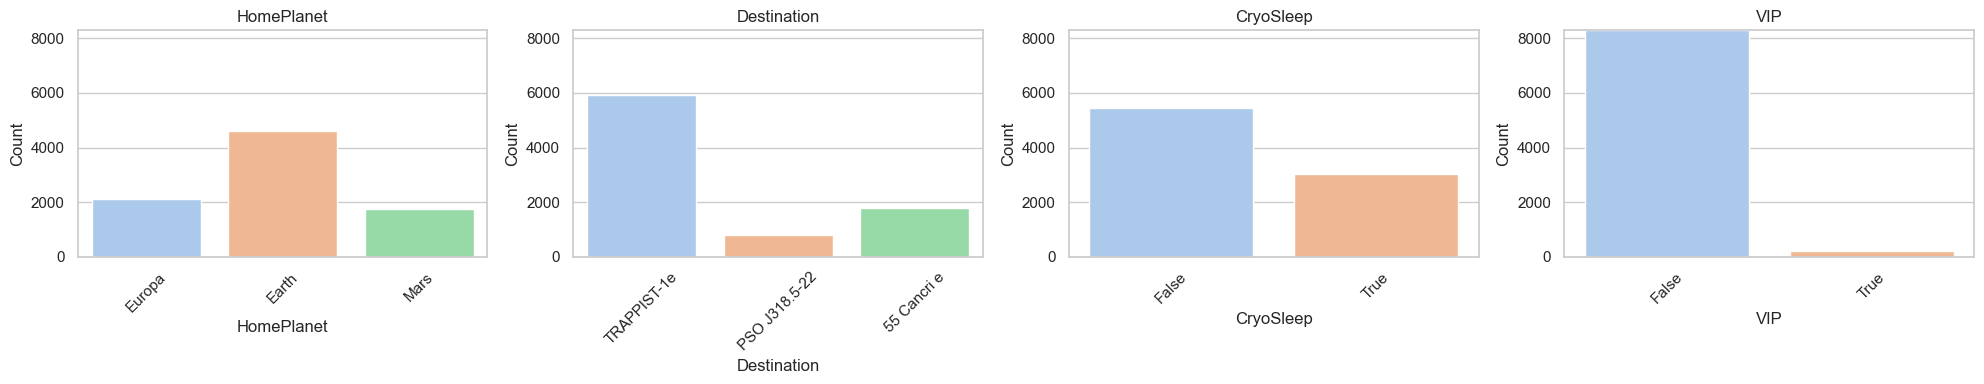

In [19]:
# Calculate a unified max y-limit across all categorical features
max_y = max([train[col].value_counts().max() for col in categorical_to_plot])

plt.figure(figsize=(20, 4))

for i, col in enumerate(categorical_to_plot, 1):
    plt.subplot(1, 4, i)
    sns.countplot(x=col, data=train, hue=col, palette="pastel", legend=False)
    plt.title(col)
    plt.ylabel("Count")
    plt.ylim(0, max_y)     # <<< unified y-axis
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Most passengers originate from Earth, with Europa and Mars forming smaller groups.
A similar concentration appears in `Destination`, where most travelers are headed to
TRAPPIST-1e while the remaining destinations represent much smaller segments.

Most passengers are not in cryosleep, making the True category a minority group that
may show different behavioral or demographic patterns.



`VIP` is even more uncommon, with very few positive cases, making it particularly
interesting to examine later in relation to the target variable. Its rarity may reflect
a small group with distinctly different resources or travel conditions, which could
influence how these passengers were affected by the anomaly.



### 2.7 Numerical Distribution Exploration

In this section, we explore the distributions of the numerical features in the dataset.

#### 2.7.1 Age Distribution
In this part, we examine the distribution of the age variable before moving on to the
spending-related features. The histogram below shows how ages are distributed among the
passengers in the dataset.

Unique ages: 80


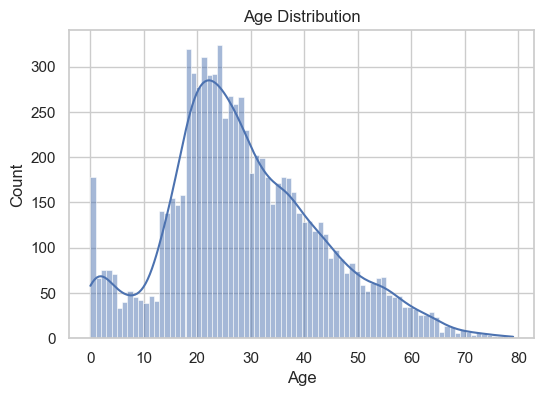

In [20]:

age_clean = train["Age"].dropna()

# Count number of unique age values (after removing NaN)
unique_age = len(train["Age"].dropna().unique())
print("Unique ages:", unique_age)

plt.figure(figsize=(6,4))
sns.histplot(age_clean, bins=unique_age, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

The age distribution shows a clear concentration of passengers in young adulthood, with the peak centered around the early twenties. There is also a noticeable group of infants under one year old. This subgroup is particularly interesting to examine later in relation to the target variable, since infants are not independent travelers and their outcome may depend on the behavior or circumstances of accompanying passengers. The distribution gradually tapers toward older ages, forming a mild right tail up to the maximum recorded age of 79.


#### 2.7.2 Spending Feature Distributions
The five spending-related features exhibit a very different structure compared to age.
Each of them contains a large proportion of zero values, with only a subset of passengers
recording any positive spending. Among those who do spend, the amounts vary widely and
extend over a broad numerical range. To capture these characteristics clearly, we first
examine the proportion of Zero vs. Non-Zero values for each feature, and then summarize
the positive spending amounts using quantiles.

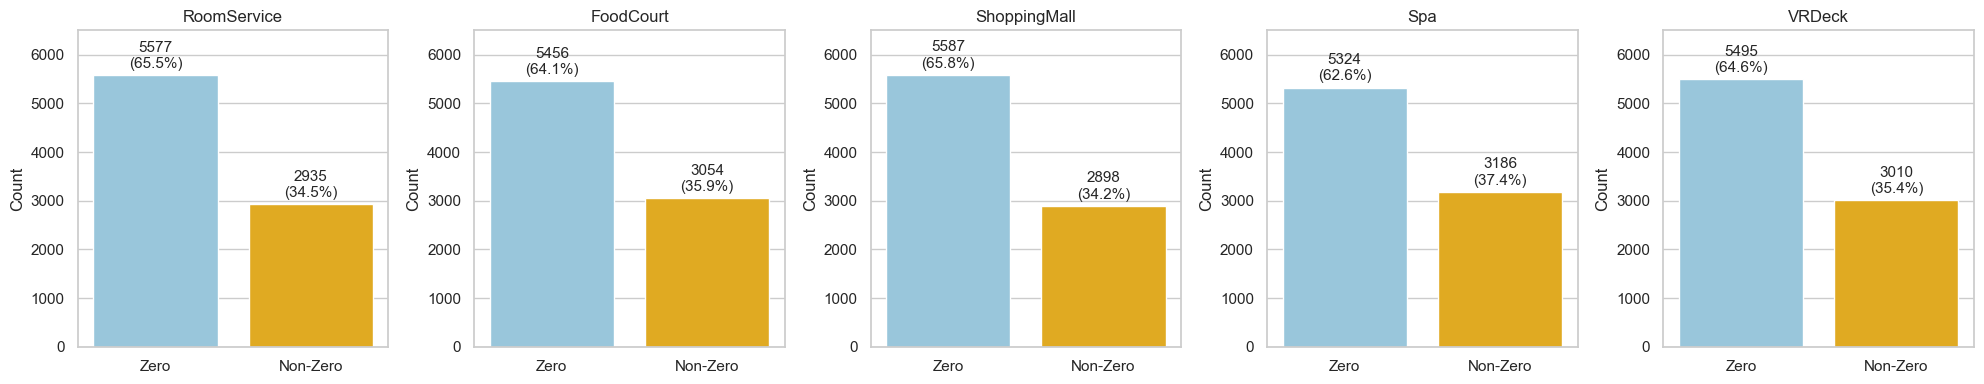

In [21]:
spend_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

plt.figure(figsize=(20, 4))

for i, col in enumerate(spend_cols, 1):

    zeros = (train[col] == 0).sum()
    nonzeros = (train[col] > 0).sum()

    total = zeros + nonzeros
    zero_pct = zeros / total * 100
    nonzero_pct = nonzeros / total * 100

    plt.subplot(1, 5, i)
    ax = sns.barplot(
        x=["Zero", "Non-Zero"],
        y=[zeros, nonzeros],
        palette=["#8ecae6", "#ffb703"],
        hue = ["Zero", "Non-Zero"],
        legend=False
    )
    plt.title(col)
    plt.ylabel("Count")
    plt.ylim(0,6500)

    # Add labels above bars
    for j, val in enumerate([zeros, nonzeros]):
        pct = zero_pct if j == 0 else nonzero_pct
        ax.text(
            j, val + total * 0.01,     # slightly above the bar
            f"{val}\n({pct:.1f}%)",
            ha="center", va="bottom", fontsize=11
        )

plt.tight_layout()
plt.show()


In [22]:
# Replace 0 with NaN so quantiles reflect positive spending only
positive_only = train[spend_cols].replace(0, np.nan)

quantiles = positive_only.quantile([0.25,0.5, 0.75, 0.9, 0.95, 0.99]).T
quantiles.columns = ["25%","50%", "75%", "90%", "95%", "99%"]

quantiles

,25%,50%,75%,90%,95%,99%
RoomService,37.0,320.0,848.00,1667.0,2413.90,4699.28
FoodCourt,39.0,396.5,1255.75,3623.1,5677.20,12060.04
ShoppingMall,22.0,195.0,693.00,1226.1,1872.45,4060.07
Spa,27.0,226.5,769.00,2143.0,3936.50,8819.45
VRDeck,28.0,260.0,806.50,2102.3,3952.90,9646.26


The spending features exhibit a consistent pattern across all five categories: roughly two-thirds of passengers record zero spending, while about one-third spend a positive amount.
Among those who do spend, the distributions are highly right-skewed, with median values ranging from 195 to 396 credits depending on the category.
Upper-tail behavior is substantial, as the 90th, 95th, and especially the 99th percentiles reach very high values, indicating a small group of heavy spenders.
The extremely large 99th-percentile values (e.g., 12,060 in FoodCourt and 9,646 in VRDeck) demonstrate that a small subset of passengers engages in unusually high spending.
This structure-many zeros, many small positive amounts, and a long right tail-confirms that all spending variables are strongly zero-inflated and heavily skewed.

## 2.8 Feature Relationships Analysis
In this section, we systematically explore how features relate to one another and to the target variable. We move beyond simple correlation patterns to employ a comprehensive bivariate analysis structure tailored to the data types: Spearman correlation for initial, robust monotonic associations; Cramér's V for definitive nominal (categorical vs. categorical) associations; and the Kruskal-Wallis H test (measuring Effect Size $\epsilon^2$) for testing median differences between categorical and numerical features. This rigorous approach allows us to confirm critical, domain-intuitive relationships (such as the connection between CryoSleep status and spending) and generates foundational statistical evidence that will inform every subsequent step, including imputation, feature engineering, and modeling.
Note that high-cardinality features such as PassengerId, Cabin and Name are excluded from this immediate analysis, as they require decomposition and construction steps which will be performed during the subsequent Data Preparation phase.


#### 2.8.1 Numerical and Binary Features (Spearman $\rho$)
We use Spearman correlation to examine relationships between the features because the spending variables are highly skewed, contain many zeros, and include extreme values. In such distributions, Pearson correlation can be misleading since it is sensitive to outliers and assumes linear relationships. Spearman, which is based on ranked values, provides a more robust measure of monotonic associations under these conditions. Binary variables such as CryoSleep, VIP, and Transported are mapped to 0/1 and are included in this matrix for visual completeness and initial indication only. However, it is important to note that the definitive analysis for the relationships involving these binary features will be performed in subsequent sections using the more statistically appropriate methods: Cramér's V (for categorical-categorical pairs) and Kruskal-Wallis (for categorical-numerical pairs).

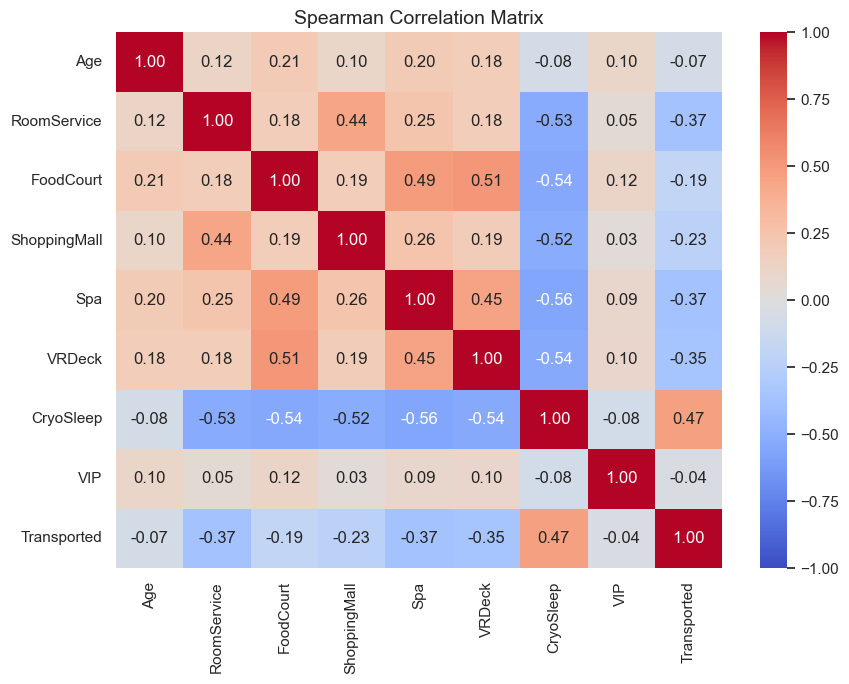

In [23]:
from notebooks.eda_utils import run_spearman_analysis

numerical_features = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
binary_features = ["CryoSleep", "VIP", "Transported"]
correlation_matrix = run_spearman_analysis(train, numerical_features, binary_features)

The spending variables show moderate positive correlations with one another (e.g., FoodCourt vs. VRDeck: $\rho \approx$ 0.51), suggesting that passengers who spend in one category tend to spend in others as well. Age exhibits only weak associations with the spending features (the highest being Age vs. FoodCourt: $\rho \approx$ 0.21), indicating that onboard expenditure is not strongly age-dependent. CryoSleep is strongly and negatively correlated with all spending variables (e.g., CryoSleep vs. Spa: $\rho \approx$ -0.56), reflecting the fact that passengers in cryosleep do not make purchases during the flight. The weak correlations involving VIP (highest is VIP vs. FoodCourt: $\rho \approx$ 0.12) should be interpreted with caution: because VIP cases are extremely rare, the limited variability reduces the statistical power to detect meaningful relationships, so low coefficients do not necessarily imply a true absence of association.The correlations with the target variable follow a clear pattern. CryoSleep shows the strongest association with Transported ($\rho \approx$ 0.47), indicating that passengers in cryosleep were much more likely to be transported. All spending features display moderate negative correlations with the outcome (e.g., Spa vs. Transported: $\rho \approx$ -0.37), which aligns with their strong negative relationship with CryoSleep: passengers who spend are generally not in cryosleep, and CryoSleep itself is positively linked to being transported. In contrast, Age and VIP exhibit only negligible associations with the target (Age: $\rho \approx$ -0.07, VIP: $\rho \approx$ -0.04), with VIP’s weak correlation likely reflecting the very small number of VIP cases.

#### 2.8.2 Categorical-Categorical Associations
To deepen our understanding of the exploratory data analysis, this section specifically examines the relationships between the key categorical and binary features in the dataset, such as HomePlanet, CryoSleep, VIP, and the target variable Transported. While initial analysis provided some insight using Spearman correlation on the encoded variables, we recognize that this method is not optimally suited for truly nominal data. Therefore, we introduce Cramér's V, a chi-square-based statistical measure explicitly designed to quantify the strength of association between two categorical variables.



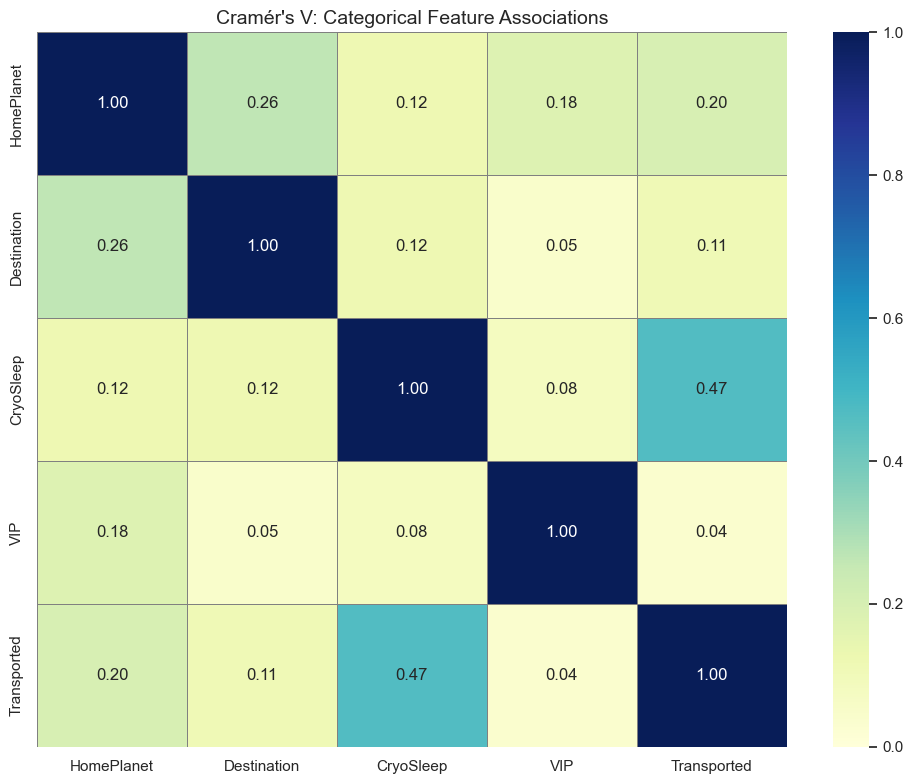

,HomePlanet,Destination,CryoSleep,VIP,Transported
HomePlanet,1.000000,0.262318,0.118587,0.177795,0.195601
Destination,0.262318,1.000000,0.120487,0.045735,0.111806
CryoSleep,0.118587,0.120487,1.000000,0.080574,0.468399
VIP,0.177795,0.045735,0.080574,1.000000,0.036871
Transported,0.195601,0.111806,0.468399,0.036871,1.000000


In [24]:
from notebooks.eda_utils import run_cramers_v_analysis

# define the full set of categorical features
features_to_test = ["HomePlanet", "Destination", "CryoSleep", "VIP", "Transported"]
cramers_results_df = run_cramers_v_analysis(train, features_to_test)
display(cramers_results_df)

The analysis using Cramér's V, which computes the strength of association based on a Contingency Matrix (a table showing the frequency count for every combination of values between two categorical variables), reveals the strength of association among key features. The resulting table displays the association strength (V), along with the p-value and contingency table dimensions (n_rows/n_cols). As anticipated for a large dataset (over 8,000 records), all computed associations were found to be highly statistically significant (p-values are close to zero). The analysis confirms that CryoSleep shows the strongest relationship with the target variable, Transported (V $\approx 0.47$), which signifies a moderate association. Weak associations were observed between HomePlanet and Destination (V $\approx 0.26$), and between HomePlanet and Transported (V $\approx 0.20$). The weakest overall association is between VIP and the target variable Transported (V $\approx 0.04$), confirming this relationship is very weak/negligible, likely due to the rarity of VIP cases in the sample.

#### 2.8.3 Categorical-Numerical Associations
The final step in our bivariate analysis is systematically testing the relationship between the key categorical variables (including the target variable, Transported) and the numerical features (Age and the spending variables). Since our descriptive analysis previously confirmed that the spending distributions are highly non-normal and zero-inflated, we must rely on non-parametric methods. Therefore, we employ the Kruskal-Wallis H test. This test is essential because it determines whether the median of each numerical feature is significantly different across the groups defined by the categorical variables. To accurately assess the practical strength of these relationships, independent of our large sample size, we also calculate the Epsilon Squared ($\epsilon^2$) Effect Size. This complete information is vital for confirming which groupings create separable distributions, providing crucial insight for feature engineering and modeling.


--- Kruskal-Wallis Results (Sorted by Effect Size) ---


,Grouping_Feature,Tested_Numerical_Feature,H_Statistic,Effect_Size,p_value
0,CryoSleep,Spa,2579.723422,0.310802,0.000000e+00
1,CryoSleep,FoodCourt,2420.404145,0.291670,0.000000e+00
2,CryoSleep,VRDeck,2390.183431,0.288062,0.000000e+00
3,CryoSleep,RoomService,2297.611700,0.276834,0.000000e+00
4,CryoSleep,ShoppingMall,2241.225860,0.270722,0.000000e+00
5,Transported,Spa,1181.196636,0.138700,7.444260e-259
6,Transported,RoomService,1172.218692,0.137612,6.652906e-257
7,Transported,VRDeck,1055.505807,0.124001,1.547481e-231
8,HomePlanet,FoodCourt,818.817745,0.098305,1.570312e-178
9,HomePlanet,RoomService,714.177181,0.085650,8.286968e-156


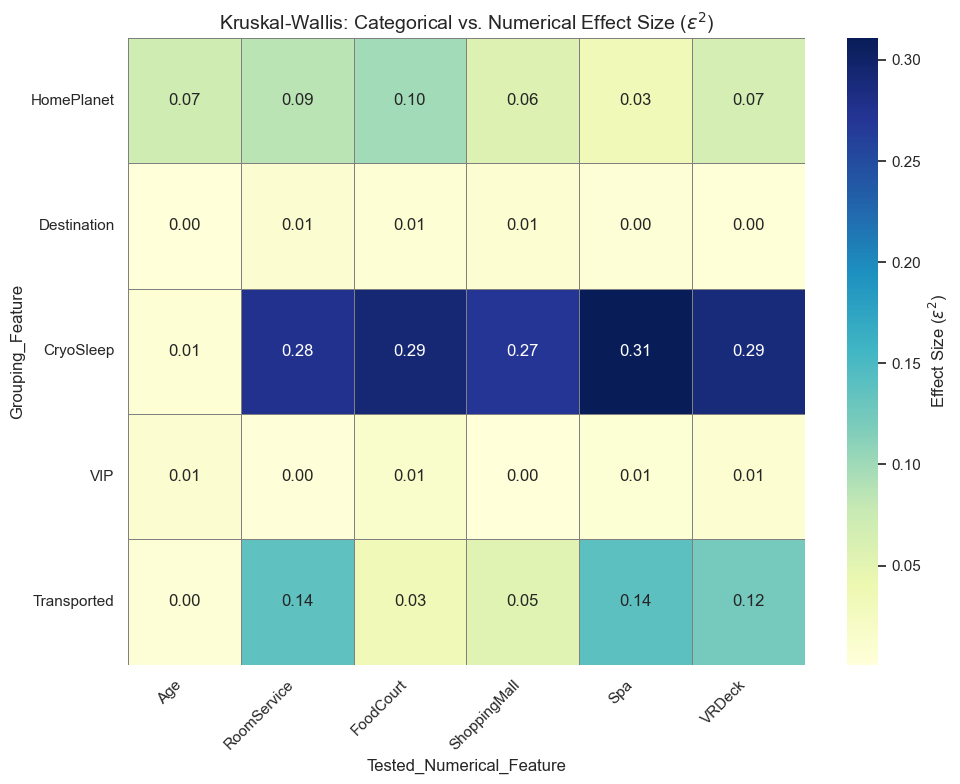

In [25]:
from notebooks.eda_utils import run_kruskal_wallis_analysis

numerical_features = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
categorical_features = ["HomePlanet", "Destination", "CryoSleep", "VIP", "Transported"]
kruskal_results_df = run_kruskal_wallis_analysis(train, categorical_features, numerical_features)

According to the resulting table and the heatmap, the analysis of the Kruskal-Wallis H test confirms that all relationships were found to be highly statistically significant (p-values approaching zero). This significance is largely a function of the large sample size, necessitating the use of the normalized Effect Size ($\epsilon^2$) to assess practical strength. The analysis reveals a very large effect between CryoSleep and all five Spending features ($\epsilon^2 \approx 0.27$ to $0.31$), confirming its dominance in explaining spending variance. A large effect ($\epsilon^2 \approx 0.12$ to $0.14$) is observed between the target variable Transported and key spending features like Spa and RoomService. Conversely, relationships involving VIP status and Destination consistently show a negligible effect size ($\epsilon^2 \le 0.01$ for most pairs). This indicates their limited, practical influence on the medians of the numerical features, particularly for VIP where the low number of positive cases restricts the statistical power to detect a stronger effect. All findings gathered across the various relationship analyses (Cramér's V, Spearman, and Kruskal-Wallis) will serve as the foundational evidence for our subsequent imputation, feature engineering, and modeling steps.

# 3. Data Preparation 💻

## 3.0 Initialization: Creating Working Datasets
We begin by creating copies of the original train and test DataFrames to ensure that the raw data remains untouched, allowing for easy validation and comparison later in the pipeline.

In [26]:
# --- 0. Initialize Working Copies ---
# Create copies to perform all preprocessing steps without modifying the original DataFrames.
train_processed = train.copy()
test_processed = test.copy()

## 3.1  Feature Engineering

### 3.1.1 Feature Decomposition

The PassengerId and Cabin columns have high cardinality and are not directly suitable for modeling. Therefore we decompose these fields into meaningful components and remove the original columns. PassengerId is split to extract the Group identifier, capturing group-level information, while Cabin is decomposed into Deck, CabinNum, and Side, which represent important spatial characteristics. This approach preserves the informative structure embedded in the original fields while avoiding the inclusion of non-informative identifiers.

In [27]:
from notebooks.feature_utils import apply_decomposition

# --- EXECUTION ---
train_processed = apply_decomposition(train_processed)
test_processed = apply_decomposition(test_processed)

train_processed.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,CabinNum,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,F,1,S


### 3.1.2 Feature Construction

We construct several features derived from existing columns to better capture passengers’ social and spending behavior: $\text{GroupSize}$ (the number of passengers in the same booking group), $\text{TotalSpent}$ (the total amount spent across all onboard services), $\text{NumSpendCategories}$ (the number of service categories with positive spending), and $\text{TravelAcompanyStatus}$ (whether the passenger travels alone, with a group, or with relatives inferred from matching surnames within the same group). Finally, we drop the Name column after extracting the relevant surname-based signal, as the remaining free-text identifier exhibits very high cardinality, which may lead to overfitting and provides no clear justification for being retained.

In [28]:
from notebooks.feature_utils import apply_feature_construction

# --- EXECUTION ---
train_processed = apply_feature_construction(train_processed)
test_processed = apply_feature_construction(test_processed)

train_processed.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,Deck,CabinNum,Side,GroupSize,TotalSpent,NumSpendCategories,TravelAcompanyStatus
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,B,0,P,1,0.0,0,Solo
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,F,0,S,1,736.0,5,Solo
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,A,0,S,2,10383.0,4,WithRelatives
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,A,0,S,2,5176.0,4,WithRelatives
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,F,1,S,1,1091.0,5,Solo


We discretize Age into an ordinal feature (Age_Group) using data-driven split points learned from a simple decision tree. The goal of this transformation is to obtain a lower-dimensional, more compact representation of age that preserves its most informative structure.

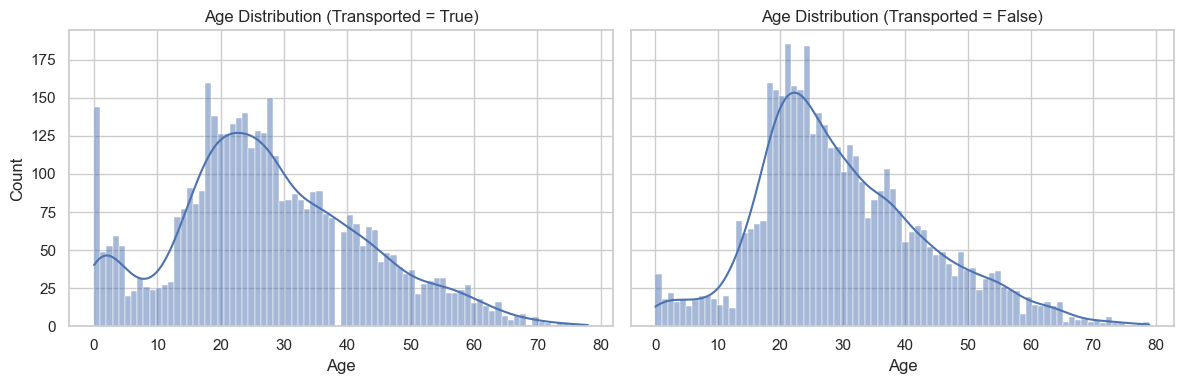

In [29]:
# Separate Age by Transported status
age_true = train.loc[train["Transported"] == True, "Age"].dropna()
age_false = train.loc[train["Transported"] == False, "Age"].dropna()

unique_age = len(train["Age"].dropna().unique())

# Plot side-by-side distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.histplot(age_true, bins=unique_age, kde=True, ax=axes[0])
axes[0].set_title("Age Distribution (Transported = True)")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Count")

sns.histplot(age_false, bins=unique_age, kde=True, ax=axes[1])
axes[1].set_title("Age Distribution (Transported = False)")
axes[1].set_xlabel("Age")

plt.tight_layout()
plt.show()

Requested Max Bins (max_leaf_nodes): 14
Minimum Samples per Bin Required: 150
Actual Optimal Split Points found: [np.float64(0.5), np.float64(4.5), np.float64(12.5), np.float64(17.5), np.float64(19.5), np.float64(24.5), np.float64(27.5), np.float64(28.5), np.float64(29.5), np.float64(32.5), np.float64(36.5), np.float64(39.5), np.float64(41.5)]


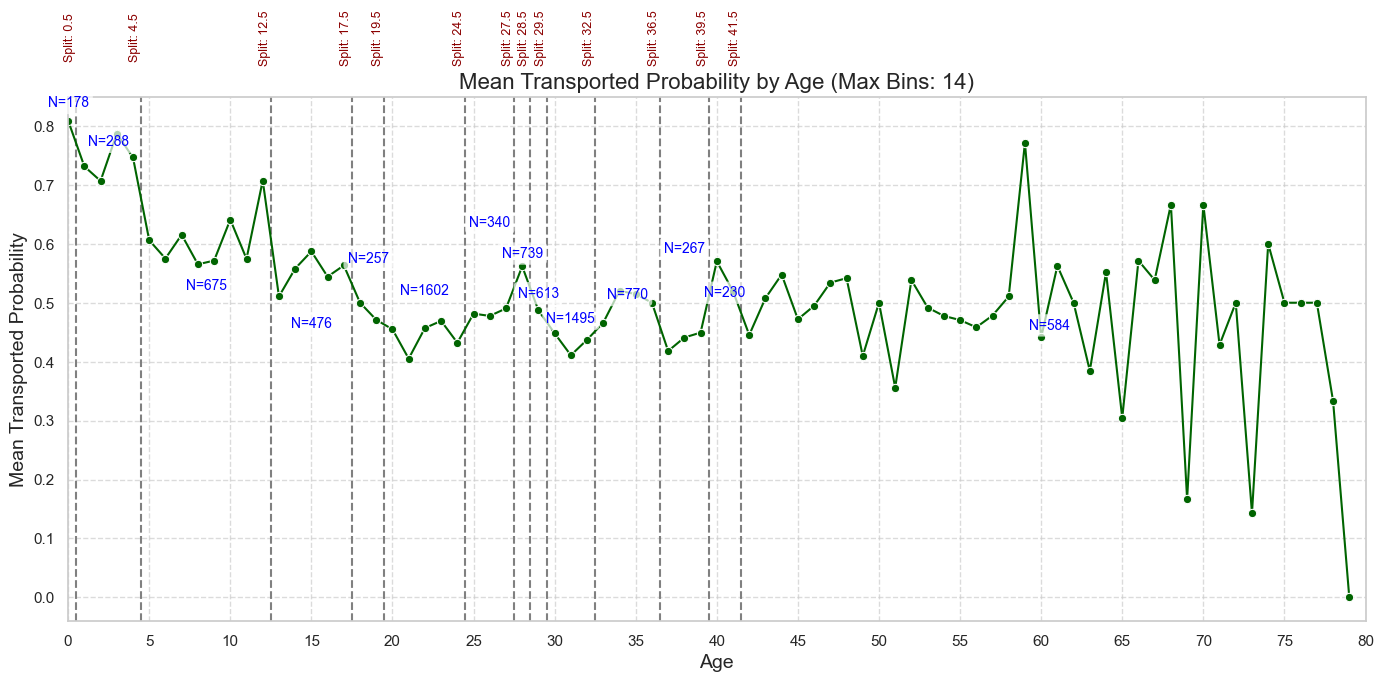

In [30]:
from notebooks.feature_utils import apply_binning_and_visualize_max_leaf

# --- EXECUTION ---
train_processed, age_split_points = apply_binning_and_visualize_max_leaf(
    train_processed, num_bins=14, min_samples_per_bin=150, min_purity_decrease=0.00005
)

# apply the SAME bins to test (no fitting, no visualization)
test_processed, _ = apply_binning_and_visualize_max_leaf(
    test_processed, split_points=age_split_points, show=False
)

To assess whether discretizing age leads to a meaningful loss of information, we conduct a controlled comparison between two feature sets that differ only in their age representation. One uses the raw continuous Age, while the other replaces it with the lower-dimensional ordinal Age_Group. All other features, preprocessing steps, models, and evaluation settings are kept identical to ensure a fair comparison.

In [31]:
# @title
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB


# -------------------------
# Target
# -------------------------
y = train_processed["Transported"].astype(int)

# -------------------------
# Feature sets (identical except Age vs Age_Group)
# -------------------------
common_features = [
    "HomePlanet", "CryoSleep", "Destination", "VIP",
    "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck",
    "Deck", "CabinNum", "Side", "GroupSize", "TotalSpent",
    "NumSpendCategories", "TravelAcompanyStatus"
]

features_age = common_features + ["Age"]
features_age_group = common_features + ["Age_Group"]

# -------------------------
# Helper: build preprocessing + evaluate with CV
# -------------------------
def evaluate_cv(X, y, model, scoring="accuracy", n_splits=10):
    # Identify columns by dtype
    numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_features = X.columns.difference(numeric_features).tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())  # good for LR; harmless for RF
            ]), numeric_features),
            ("cat", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), categorical_features),
        ],
        remainder="drop"
    )

    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X, y, cv=cv, scoring=scoring)
    return scores

# -------------------------
# Prepare X
# -------------------------
X_age = train_processed[features_age]
X_age_group = train_processed[features_age_group]

# -------------------------
# Models
# -------------------------
lr = LogisticRegression(max_iter=4000, random_state=42)
rf = RandomForestClassifier(n_estimators=600, random_state=42, class_weight="balanced")
svm = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
nb = BernoulliNB(alpha=1.0)

models = {
    "LogReg": lr,
    "RandFor": rf,
    "SVM": svm,
    "NaiveBayes": nb
}

scoring = "accuracy"  # keep the same scoring for fair comparison

print(f"\n=== Scoring: {scoring} | 10-Fold Stratified CV ===")
for name, model in models.items():
    scores_age = evaluate_cv(X_age, y, model, scoring=scoring)
    scores_ageg = evaluate_cv(X_age_group, y, model, scoring=scoring)

    print(f"{name:<9} | Age      : {scores_age.mean():.4f} ± {scores_age.std():.4f}")
    print(f"{name:<9} | Age_Group: {scores_ageg.mean():.4f} ± {scores_ageg.std():.4f}")
    print("-" * 55)


=== Scoring: accuracy | 10-Fold Stratified CV ===
LogReg    | Age      : 0.7944 ± 0.0175
LogReg    | Age_Group: 0.7921 ± 0.0153
-------------------------------------------------------
RandFor   | Age      : 0.8011 ± 0.0133
RandFor   | Age_Group: 0.8019 ± 0.0126
-------------------------------------------------------
SVM       | Age      : 0.8013 ± 0.0172
SVM       | Age_Group: 0.8037 ± 0.0169
-------------------------------------------------------
NaiveBayes | Age      : 0.7431 ± 0.0188
NaiveBayes | Age_Group: 0.7459 ± 0.0180
-------------------------------------------------------


The results indicate that using Age_Group yields performance comparable to, and in several cases slightly better than, raw Age across the tested models. This observation motivates our decision to proceed with the ordinal representation, likely because it reduces sensitivity to fine-grained variations that can lead to overfitting and thus promotes better generalization.

In [32]:
train_processed.drop(columns=['Age'], inplace=True)
test_processed.drop(columns=['Age'], inplace=True)

An additional observation is that Naive Bayes consistently underperforms relative to the other models. This is expected, as its assumption of conditional independence given the class label is unlikely to hold in our setting, with several features remaining strongly dependent even after conditioning on the target (e.g., spending and group-related attributes), motivating its exclusion from subsequent modeling stages.

### 3.1.3 Post-Feature Engineering Relationship Analysis
In this section, we repeat the same relationship analyses performed on the raw dataset in Section 2.8, now applied to the engineered dataset, to examine how the feature transformations affect dependencies between variables. The analysis focuses on numerical, categorical, and binary features, including both original and engineered variables. The Group variable is not included, as it primarily serves as a high-cardinality contextual identifier. While it is excluded from general dependency analyses, it may be examined separately in the context of group-based consistency and imputation, where its role as a contextual identifier is meaningful.


In [33]:
# -------------------------
# Feature Groups Definition
# -------------------------

# Binary features (0/1 or True/False)
BINARY_FEATURES = [
    "CryoSleep",
    "VIP",
    "Transported"
]

# Numerical / Continuous features
NUMERICAL_FEATURES = [
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "TotalSpent",
    "GroupSize",
    "NumSpendCategories",
    "CabinNum"
    ]

# Categorical / Nominal or Ordinal features
CATEGORICAL_FEATURES = [
    "HomePlanet",
    "Destination",
    "Deck",
    "Side",
    "TravelAcompanyStatus",
    "Age_Group"
]

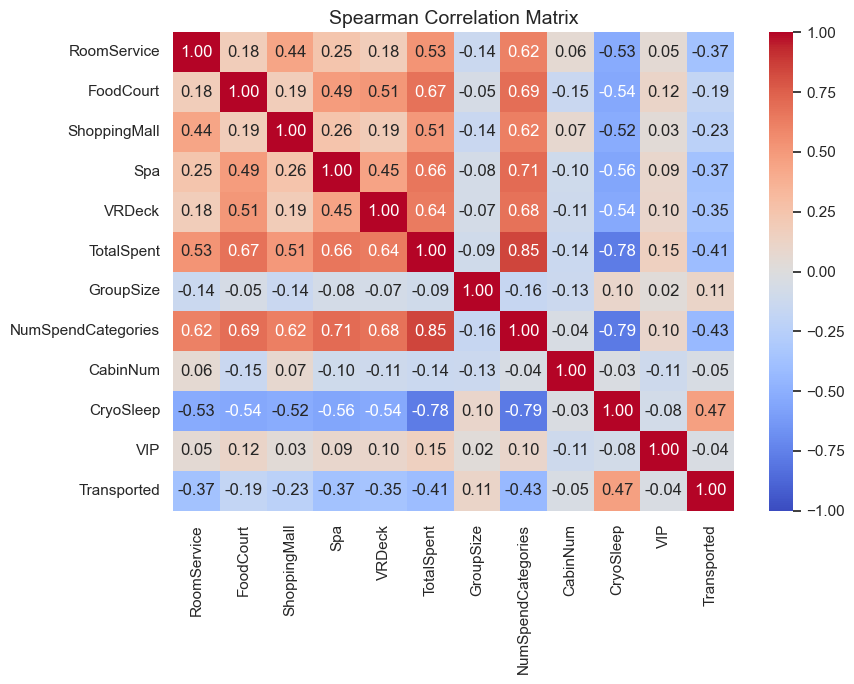

In [34]:
# @title
spearman_corr = run_spearman_analysis(
    train_processed,
    numeric_cols=NUMERICAL_FEATURES,
    binary_cols=BINARY_FEATURES
)

#display(spearman_corr)


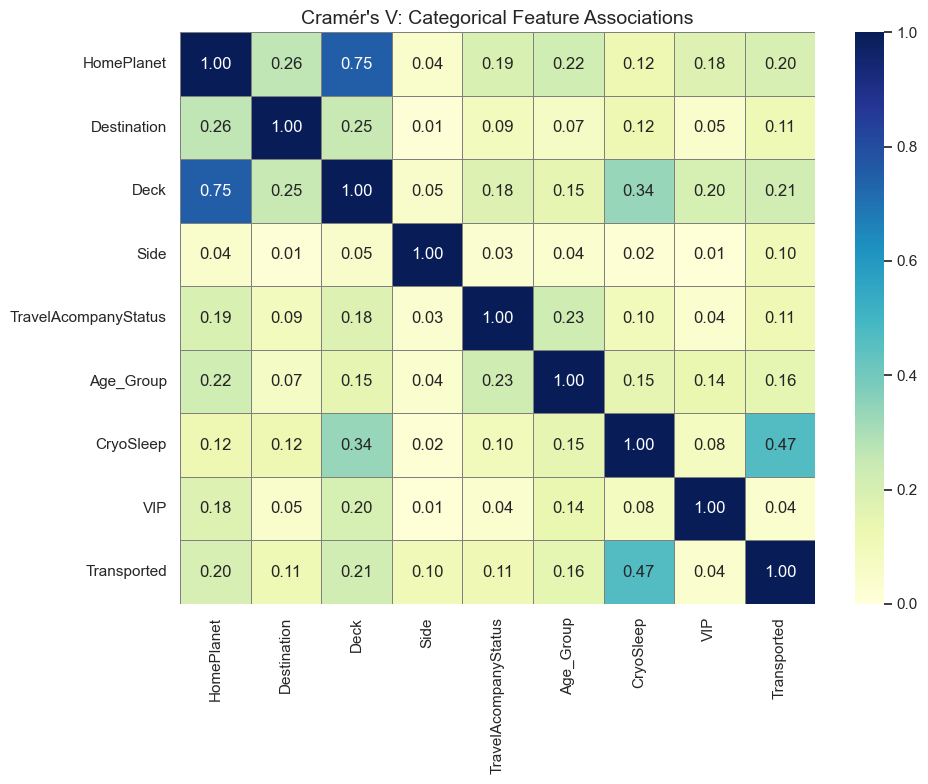

,HomePlanet,Destination,Deck,Side,TravelAcompanyStatus,Age_Group,CryoSleep,VIP,Transported
HomePlanet,1.000000,0.262318,0.753592,0.040572,0.191982,0.222155,0.118587,0.177795,0.195601
Destination,0.262318,1.000000,0.247201,0.014073,0.086954,0.068209,0.120487,0.045735,0.111806
Deck,0.753592,0.247201,1.000000,0.047135,0.183585,0.148872,0.335142,0.201298,0.214905
Side,0.040572,0.014073,0.047135,1.000000,0.034852,0.035847,0.019425,0.009317,0.103540
TravelAcompanyStatus,0.191982,0.086954,0.183585,0.034852,1.000000,0.225556,0.097992,0.035609,0.113945
Age_Group,0.222155,0.068209,0.148872,0.035847,0.225556,1.000000,0.148633,0.135642,0.155610
CryoSleep,0.118587,0.120487,0.335142,0.019425,0.097992,0.148633,1.000000,0.080574,0.468399
VIP,0.177795,0.045735,0.201298,0.009317,0.035609,0.135642,0.080574,1.000000,0.036871
Transported,0.195601,0.111806,0.214905,0.103540,0.113945,0.155610,0.468399,0.036871,1.000000


In [35]:
# @title
cramers_results_df = run_cramers_v_analysis(
    train_processed,
    categorical_features=CATEGORICAL_FEATURES + BINARY_FEATURES
)

display(cramers_results_df)


--- Kruskal-Wallis Results (Sorted by Effect Size) ---


,Grouping_Feature,Tested_Numerical_Feature,H_Statistic,Effect_Size,p_value
0,TravelAcompanyStatus,GroupSize,7841.582146,0.902035,0.000000
1,CryoSleep,NumSpendCategories,4690.894347,0.617823,0.000000
2,CryoSleep,TotalSpent,4589.762429,0.604500,0.000000
3,Deck,CabinNum,3811.425554,0.448265,0.000000
4,CryoSleep,Spa,2579.723422,0.310802,0.000000
...,...,...,...,...,...
76,Side,NumSpendCategories,0.763926,0.000000,0.382103
77,Side,TotalSpent,0.926206,0.000000,0.335851
78,Side,VRDeck,0.899038,0.000000,0.343040
79,Side,Spa,0.013496,0.000000,0.907514


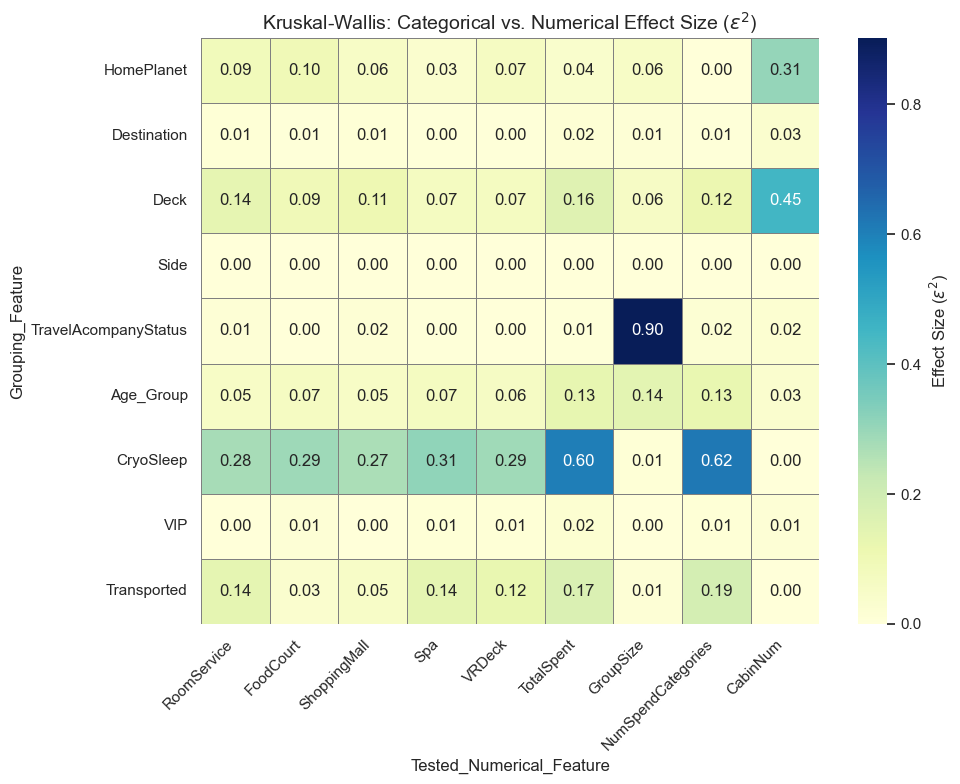

In [36]:
# @title
kruskal_results_df = run_kruskal_wallis_analysis(
    train_processed,
    cat_cols=CATEGORICAL_FEATURES + BINARY_FEATURES,
    num_cols=NUMERICAL_FEATURES
)

### 3.1.4 Final Feature Selection

 #### VIP Feature Assessment
Although earlier association measures showed weak relationships involving the VIP feature, this result is strongly influenced by the very small number of positive VIP cases in the dataset. Because VIP passengers represent only a small fraction of all records, correlation and association metrics may underestimate their potential relevance. For this reason, we explicitly examine the relationship between VIP status and the target variable by focusing on the Transported rates within the positive VIP subgroup.








In [37]:
# --- VIP Focused Transported Analysis ---

# 1. Calculate overall survival rate (for comparison)
overall_transported_mean = train_processed['Transported'].mean()

# 2. Analyze VIP=True subset
vip_subset = train_processed[train_processed['VIP'] == True]
vip_transported_mean = vip_subset['Transported'].mean()

# 3. Analyze VIP=False subset
not_vip_subset = train_processed[train_processed['VIP'] == False]
not_vip_transported_mean = not_vip_subset['Transported'].mean()

print("\n--- VIP Transported Contribution Analysis ---")
print(f"Overall Transported Rate (Baseline): {overall_transported_mean:.4f}")
print(f"Transported Rate for VIP=True (n={len(vip_subset)}): {vip_transported_mean:.4f}")
print(f"Transported Rate for VIP=False (n={len(not_vip_subset)}): {not_vip_transported_mean:.4f}")


--- VIP Transported Contribution Analysis ---
Overall Transported Rate (Baseline): 0.5036
Transported Rate for VIP=True (n=199): 0.3819
Transported Rate for VIP=False (n=8291): 0.5063


The overall transport rate is 50.36%. VIP passengers exhibit a lower transport rate (38.19%) compared to non-VIP passengers (50.63%). Although the VIP group is small (199 cases), this difference suggests that VIP status may still carry informative signal. Therefore, despite its weak correlations observed earlier, VIP is retained as a potentially useful feature for future classification models.

## 3.2  Handling Missing Values (Imputation)

In [38]:
# Missing values count
missing_count = train_processed.isna().sum()

# Missing values percent
missing_percent = (train_processed.isna().mean() * 100).round(2)

# Combine into a single DataFrame
missing_table = pd.concat(
    [missing_count, missing_percent],
    axis=1
)

missing_table.columns = ["Missing_Count", "Missing_Percent (%)"]

# Sort from most missing to least
missing_table.sort_values("Missing_Count", ascending=False)

,Missing_Count,Missing_Percent (%)
TotalSpent,908,10.45
NumSpendCategories,908,10.45
CryoSleep,217,2.50
ShoppingMall,208,2.39
VIP,203,2.34
HomePlanet,201,2.31
Deck,199,2.29
CabinNum,199,2.29
Side,199,2.29
VRDeck,188,2.16


In [39]:
train_processed.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,Deck,CabinNum,Side,GroupSize,TotalSpent,NumSpendCategories,TravelAcompanyStatus,Age_Group
0,Europa,False,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,0.0,False,1,B,0,P,1,0.0,0,Solo,Age_Bin_11
1,Earth,False,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,44.0,True,2,F,0,S,1,736.0,5,Solo,Age_Bin_5
2,Europa,False,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,49.0,False,3,A,0,S,2,10383.0,4,WithRelatives,Age_Bin_13
3,Europa,False,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,193.0,False,3,A,0,S,2,5176.0,4,WithRelatives,Age_Bin_10
4,Earth,False,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,2.0,True,4,F,1,S,1,1091.0,5,Solo,Age_Bin_3


### 3.2.1 Imputing Categorical Features

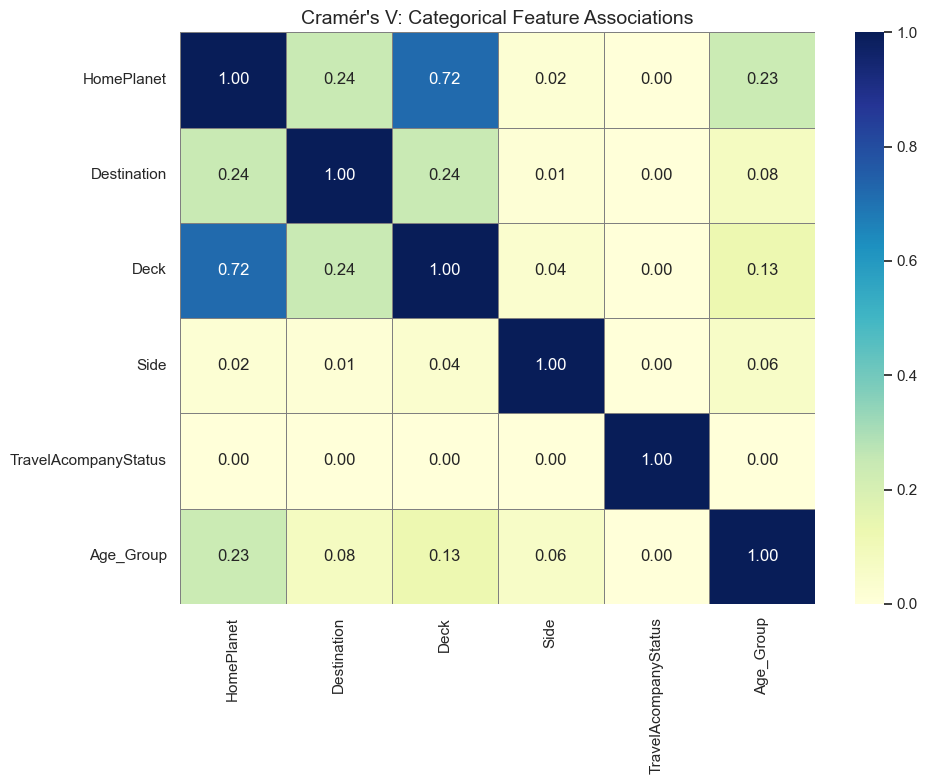

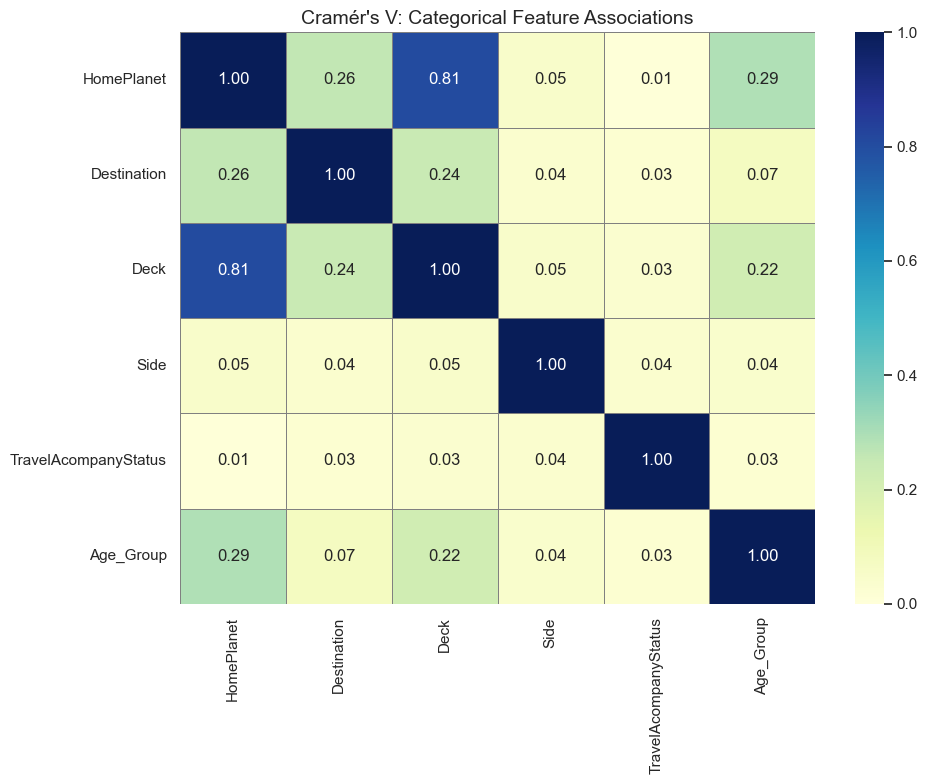

,HomePlanet,Destination,Deck,Side,TravelAcompanyStatus,Age_Group
HomePlanet,1.000000,0.243719,0.720424,0.023113,0.0,0.234635
Destination,0.243719,1.000000,0.243492,0.014548,0.0,0.075128
Deck,0.720424,0.243492,1.000000,0.038870,0.0,0.127164
Side,0.023113,0.014548,0.038870,1.000000,0.0,0.055651
TravelAcompanyStatus,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
Age_Group,0.234635,0.075128,0.127164,0.055651,0.0,1.000000



--- Cramers Contribution Analysis for  ---


In [40]:
loners_train = train_processed[train_processed['TravelAcompanyStatus']=="Solo"]
group_train = train_processed[train_processed['TravelAcompanyStatus']!="Solo"]
corr_loners = run_cramers_v_analysis(loners_train,CATEGORICAL_FEATURES)
corr_group = run_cramers_v_analysis(group_train,CATEGORICAL_FEATURES)
display(corr_loners)
print("\n--- Cramers Contribution Analysis for  ---")


### 3.2.2 Imputing Numerical Features

In [41]:
#vip check
df_clean = group_train[group_train["VIP"].notna()].copy()

# Use transform to get the size of each group mapped back to every row
group_sizes = df_clean.groupby("Group")["Group"].transform("count")

# Filter for groups with more than 1 person
df_multi_group = df_clean[group_sizes > 1]
print(df_multi_group).count()
# Now find groups where the VIP status is consistent (all same value)
# nunique == 1 means every non-null VIP value in that group is the same
result = df_multi_group[df_multi_group.groupby("Group")["VIP"].transform("nunique") == 1].count()

print(result)




     HomePlanet CryoSleep  Destination    VIP  RoomService  FoodCourt  \
2        Europa     False  TRAPPIST-1e   True         43.0     3576.0   
3        Europa     False  TRAPPIST-1e  False          0.0     1283.0   
6         Earth     False  TRAPPIST-1e  False         42.0     1539.0   
7         Earth      True  TRAPPIST-1e  False          0.0        0.0   
9        Europa      True  55 Cancri e  False          0.0        0.0   
...         ...       ...          ...    ...          ...        ...   
8685     Europa     False  TRAPPIST-1e  False          0.0        0.0   
8686     Europa     False  TRAPPIST-1e  False          1.0     1146.0   
8687     Europa       NaN  TRAPPIST-1e  False          0.0     3208.0   
8691     Europa     False  55 Cancri e  False          0.0     1049.0   
8692     Europa     False  TRAPPIST-1e  False        126.0     4688.0   

      ShoppingMall     Spa  VRDeck  Transported  Group Deck  CabinNum Side  \
2              0.0  6715.0    49.0        Fal

AttributeError: 'NoneType' object has no attribute 'count'

## 3.3 Data Scaling and Encoding

### 3.3.1 Numerical Scaling

The following imputation rule is motivated by the expectation that passengers in CryoSleep do not actively use onboard services and therefore should not incur spending. Before applying this rule, we verify whether this assumption is indeed supported by the observed data by examining the spending behavior of passengers marked as CryoSleep == True.

In [ ]:
SPEND_COLS = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

cryo_true = train_processed[train_processed["CryoSleep"] == True]

print("Positive spending counts for CryoSleep == True:\n")

for col in SPEND_COLS:
    count = (cryo_true[col] > 0).sum()
    print(f"{col:<15}: {count}")

The results show that no passenger with CryoSleep == True incurred positive spending in any onboard service category. This supports the validity of the underlying assumption, and we therefore proceed to deterministically impute missing spending values as zero for passengers in CryoSleep.

In [ ]:
SPEND_COLS = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

# Impute missing spending as 0 for CryoSleep == True (apply to both train and test)
for df in [train_processed, test_processed]:
    mask = df["CryoSleep"] == True
    df.loc[mask, SPEND_COLS] = df.loc[mask, SPEND_COLS].fillna(0)


This rule is motivated by the expectation that any positive onboard spending implies that the passenger was not in CryoSleep. Before applying it, we verify whether passengers with positive spending are ever labeled as CryoSleep == True in the data.

In [ ]:
SPEND_COLS = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

# Rows with any positive spending
has_positive_spend = (train_processed[SPEND_COLS] > 0).any(axis=1)

# Among them, count CryoSleep == True
violations = train_processed.loc[has_positive_spend, "CryoSleep"] == True

print("Rule validation:")
print(f"Passengers with any positive spending: {has_positive_spend.sum()}")
print(f"CryoSleep == True among them: {violations.sum()}")
print(f"Violation rate: {violations.mean():.4%}")

The results show that passengers with positive onboard spending are never labeled as CryoSleep == True. This supports the assumption that any positive spending implies CryoSleep = False, and we therefore use this relation to impute missing CryoSleep values.

In [ ]:
# Impute CryoSleep = False when positive spending is observed (only for missing values)
for name, df in [("Train", train_processed), ("Test", test_processed)]:
    mask = (df[SPEND_COLS] > 0).any(axis=1) & df["CryoSleep"].isna()
    df.loc[mask, "CryoSleep"] = False

    remaining = df["CryoSleep"].isna().sum()
    print(f"{name} set - remaining CryoSleep missing values: {remaining}")

At this stage, a small number of CryoSleep values remain missing. To determine how to handle these cases, we next examine the distribution of CryoSleep among passengers with zero spending across all categories, in order to assess whether a systematic tendency exists that can guide the imputation.

In [ ]:
SPEND_COLS = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

# Passengers with all spending equal to 0
all_zero_spend = (train_processed[SPEND_COLS] == 0).all(axis=1)

# CryoSleep distribution (percentages)
cryo_percent = (
        train_processed.loc[all_zero_spend, "CryoSleep"]
        .value_counts(normalize=True, dropna=False) * 100
)

print("CryoSleep percentage among passengers with all-zero spending:\n")
print(cryo_percent.round(2))


In [ ]:
SPEND_COLS = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

for name, df in [("Train", train_processed), ("Test", test_processed)]:
    missing_cryo = df["CryoSleep"].isna()

    # All spending observed (no NaN) and equal to 0
    all_zero_no_nan = (
            (df[SPEND_COLS].notna().all(axis=1)) &
            ((df[SPEND_COLS] == 0).all(axis=1))
    )

    count = (missing_cryo & all_zero_no_nan).sum()
    total_missing = missing_cryo.sum()

    print(f"{name} set:")
    print(f"  CryoSleep missing total          : {total_missing}")
    print(f"  Missing CryoSleep with all-zero spending (no NaN): {count}")


The vast majority of remaining missing CryoSleep values correspond to passengers whose spending is fully observed and equal to zero across all categories. Given this strong pattern and the small number of remaining cases, we proceed with a pragmatic imputation and assign CryoSleep = True for the remaining missing values.

In [ ]:
# Impute remaining CryoSleep as True (all-zero spending cases)
for name, df in [("Train", train_processed), ("Test", test_processed)]:
    remaining_mask = df["CryoSleep"].isna()
    df.loc[remaining_mask, "CryoSleep"] = True

    print(f"{name} set - CryoSleep missing after final imputation: {df['CryoSleep'].isna().sum()}")


In [ ]:
SPEND_COLS = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

spearman_corr = run_spearman_analysis(
    train_processed,
    numeric_cols=SPEND_COLS,
    binary_cols=[]
)

display(spearman_corr)

### 3.3.2 Categorical Encoding

# 4. Modeling

This section implements the models defined in the project proposal (page 3):

### Baseline models
- Naive Bayes
- Logistic Regression
- Support Vector Machine (SVM)

### Advanced models
- Random Forest
- XGBoost
- Neural Network (simple MLP)

Each model will be trained using a stratified train/validation split and evaluated using
classification accuracy as the primary metric (Kaggle metric).

Hyperparameter tuning (grid search or randomized search) will be applied to the most
promising models.


# 5. Evaluation

This section compares and analyzes the performance of all models using:

- Accuracy (primary metric)
- Confusion matrix
- Precision, recall, F1-score (optional)
- Feature importance (tree-based models)
- SHAP/LIME explanations (optional but valuable)

Finally, we revisit the initial model expectations stated in the proposal and discuss
which models performed best, why, and what could be improved if the project continued.


In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

def impute_all_categorical(df):
    df_imp = df.copy()
    
    def impute_by_mode(df, target_col, group_col):
        before = df[target_col].isna().sum()
        mode_map = df.dropna(subset=[target_col, group_col]).groupby(group_col)[target_col].agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None)
        mask = df[target_col].isna() & df[group_col].notna()
        df.loc[mask, target_col] = df.loc[mask, group_col].map(mode_map)
        after = df[target_col].isna().sum()
        print(f"  {target_col}: {before} → {after} ({before - after} imputed)")
        return df
    
    def knn_impute_categorical(df, cols):
        """KNN impute for remaining missing in categorical cols"""
        encoders = {col: LabelEncoder().fit(df[col].dropna()) for col in cols}
        encoded = pd.DataFrame({col: df[col].map(lambda x: encoders[col].transform([x])[0] if pd.notna(x) else np.nan) for col in cols})
        imputed = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(encoded), columns=cols)
        for col in cols:
            mask = df[col].isna()
            before = mask.sum()
            vals = np.clip(np.round(imputed.loc[mask, col]).astype(int), 0, len(encoders[col].classes_)-1)
            df.loc[mask, col] = encoders[col].inverse_transform(vals)
            print(f"  {col}: {before} → {df[col].isna().sum()} (KNN)")
        return df
    
    # 0) cabin features by Group, then KNN for rest
    print("Step 0: Cabin features by Group mode")
    for col in ['Deck', 'Side', 'CabinNum']:
        df_imp = impute_by_mode(df_imp, col, 'Group')
    print("  KNN for remaining:")
    df_imp = knn_impute_categorical(df_imp, ['Deck', 'Side'])
    # CabinNum: numeric, simple KNN
    before = df_imp['CabinNum'].isna().sum()
    df_imp['CabinNum'] = KNNImputer(n_neighbors=5).fit_transform(df_imp[['CabinNum']])
    print(f"  CabinNum: {before} → {df_imp['CabinNum'].isna().sum()} (KNN)")
    print()
    
    # 1-4) rest
    print("Step 1: HomePlanet by Deck mode")
    df_imp = impute_by_mode(df_imp, 'HomePlanet', 'Deck')
    print("\nStep 2: Destination by Deck mode")
    df_imp = impute_by_mode(df_imp, 'Destination', 'Deck')
    print("\nStep 3: Age_Group by HomePlanet mode")
    df_imp = impute_by_mode(df_imp, 'Age_Group', 'HomePlanet')
    print("\nStep 4: VIP → False")
    before = df_imp['VIP'].isna().sum()
    df_imp['VIP'] = df_imp['VIP'].fillna(False)
    print(f"  VIP: {before} → 0 ({before} imputed)")
    
    return df_imp

print("="*50 + "\nTRAIN SET\n" + "="*50)
train_processed = impute_all_categorical(train_processed)
print("\n" + "="*50 + "\nTEST SET\n" + "="*50)
test_processed = impute_all_categorical(test_processed)